# М5: Прогноз продаж
Есть иерархические данные о продажах Walmart, крупнейшей в мире компании по выручке, для прогнозирования ежедневных продаж на следующие 28 дней. Данные охватывают магазины в трех штатах США (Калифорния, Техас и Висконсин) и включают уровень товара, отдел, категории товаров и сведения о магазине. Кроме того, в нем есть объясняющие переменные, такие как цена, акции, день недели и специальные мероприятия.

https://www.kaggle.com/c/m5-forecasting-accuracy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
from tqdm.notebook import tqdm as tqdm

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")

### load data

In [2]:
# исторические данные о ежедневных продажах единицы продукции по продукту и магазину [d_1 - d_1913]
train = pd.read_csv('sales_train_validation.csv')
print(train.shape)
train.head()

(30490, 1919)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [3]:
# Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)
# лейблы для следующих 28 дней для прогноза
train_addit = pd.read_csv('sales_train_evaluation.csv')
print(train_addit.shape)
train_addit.head()

(30490, 1947)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [4]:
# Содержит информацию о датах продажи товаров
calendar = pd.read_csv('calendar.csv')
print(calendar.shape)
calendar.head()

(1969, 14)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [5]:
# Содержит информацию о цене товаров, проданных в каждом магазине, и дате.
sell_prices = pd.read_csv('sell_prices.csv')
print(sell_prices.shape)
sell_prices.head()

(6841121, 4)


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


# EDA

In [6]:
print('Всего данных в трейне:', train.shape)
print('Число уникальных товаров:', train['item_id'].nunique())
print('Число уникальных категорий товаров:', train['cat_id'].nunique(), train['cat_id'].unique())
print('Число уникальных магазинов:', train['store_id'].nunique())
print('Число уникальных штатов:', train['state_id'].nunique(), train['state_id'].unique())

Всего данных в трейне: (30490, 1919)
Число уникальных товаров: 3049
Число уникальных категорий товаров: 3 ['HOBBIES' 'HOUSEHOLD' 'FOODS']
Число уникальных магазинов: 10
Число уникальных штатов: 3 ['CA' 'TX' 'WI']


In [7]:
train['store_id'].unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

Посмотрим на общие продажи в целом

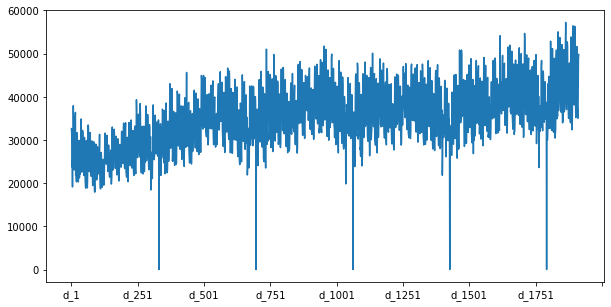

In [13]:
train.iloc[:,6:].sum().plot(figsize=(10, 5));

Продажи в целом растут. Мы можем различить некоторую ежегодную сезонность и падение на Рождество, которое является единственным днем в году, когда магазины закрыты.

Посмотрим на продажи одного из товаров (хобби-1) для примера

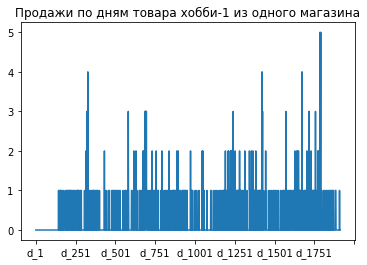

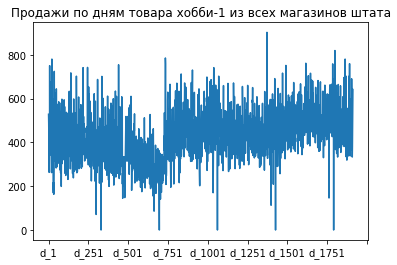

In [22]:
# продажи по дням в штате CA, товара хобби_1
train[(train['state_id'] == 'CA') & (train['store_id'] == 'CA_1') & 
      (train['cat_id'] == 'HOBBIES') & (train['dept_id'] == 'HOBBIES_1')].iloc[1,6:].plot()
plt.title('Продажи по дням товара хобби-1 из одного магазина')
plt.show()
plt.close()
train[(train['state_id'] == 'CA') & (train['store_id'] == 'CA_1') & 
      (train['cat_id'] == 'HOBBIES') & (train['dept_id'] == 'HOBBIES_1')].iloc[:,6:].sum().plot()
plt.title('Продажи по дням товара хобби-1 из всех магазинов штата');

Данные о продажах неустойчивы из-за того, что на продажи в определенный день влияет много факторов. Например, когда количество продаж равно нулю, это значит, что определенного продукта может не быть в наличии в магазине в этот день, а не только просто не покупают, потому что не хотят.

### Denoising

Необходимо снизить высокую волатильность продаж, чтобы выявить основные тенденции. Этот метод может привести к потере некоторой информации из исходного временного ряда, но он может быть полезен для извлечения определенных характеристик, касающихся тенденций во временном ряду.

**Wavelet denoising**  
Вейвлет-шумоподавление (обычно используется с электрическими сигналами) - это способ удаления ненужного шума из временного ряда. Этот метод вычисляет коэффициенты, называемые "вейвлет-коэффициентами". Эти коэффициенты определяют, какие фрагменты информации следует сохранить (сигнал), а какие отбросить (шум).

Используем значение MAD (среднее абсолютное отклонение), чтобы понять случайность в продажах и, соответственно, определить минимальный порог для вейвлет-коэффициентов во временном ряду. Отфильтровываем низкие коэффициенты из вейвлетов и восстанавливаем данные о продажах по оставшимся коэффициентам, и все; мы успешно удалили шум из данных о продажах.

In [23]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    return pywt.waverec(coeff, wavelet, mode='per')

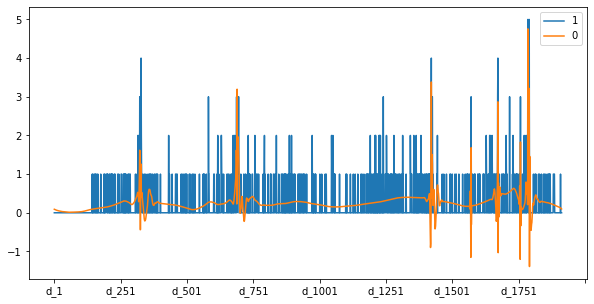

In [24]:
x = train[(train['state_id'] == 'CA') & (train['store_id'] == 'CA_1') & 
      (train['cat_id'] == 'HOBBIES') & (train['dept_id'] == 'HOBBIES_1')].iloc[1,6:]
y = denoise_signal(x.values)
x = pd.DataFrame(x)
x = x.join(pd.DataFrame(y[:-1],index=x.index))

x.plot(figsize=(10, 5));

На приведенных выше графиках оранжевая линия диаграммы представляет продажи с пониженным уровнем шума, а синие столбцы представляют исходные продажи. Мы видим, что вейвлет-шумоподавление способно успешно находить "общую тенденцию" в данных о продажах, не отвлекаясь на шум. Поиск этих высоких тенденций или закономерностей в продажах может быть полезен при создании функций для обучения модели.

**Average smoothing**  
Среднее сглаживание - это относительно простой способ уменьшения шума данных временных рядов. В этом методе мы берем "окно" (kernel_size) с фиксированным размером (например, 10). Сначала мы помещаем окно в начало временного ряда (первые десять элементов) и вычисляем среднее значение этого раздела. Теперь мы перемещаем окно по временному ряду в прямом направлении определенным "шагом" ("stride"), вычисляем среднее значение нового окна и повторяем процесс, пока не достигнем конца временного ряда. Все средние значения, которые мы рассчитали, затем объединяются в новый временной ряд, который формирует данные о продажах с пониженным уровнем шума.

In [25]:
def average_smoothing(signal, kernel_size=3, stride=1):
    sample = []
    start = 0
    end = kernel_size
    while end <= len(signal):
        start = start + stride
        end = end + stride
        sample.extend(np.ones(end - start)*np.mean(signal[start:end]))
    return np.array(sample)

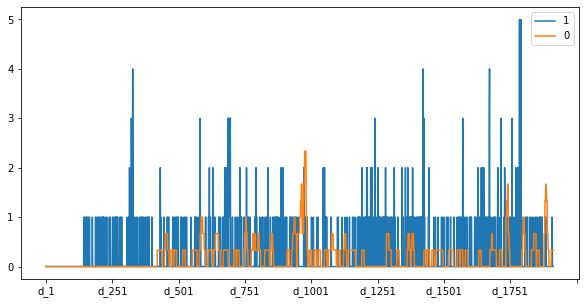

In [26]:
x = train[(train['state_id'] == 'CA') & (train['store_id'] == 'CA_1') & 
      (train['cat_id'] == 'HOBBIES') & (train['dept_id'] == 'HOBBIES_1')].iloc[1,6:]
y = average_smoothing(x)
x = pd.DataFrame(x)
x = x.join(pd.DataFrame(y[:len(x)],index=x.index))

x.plot(figsize=(10, 5));

На приведенных выше графиках оранжевая линия представляет продажи с пониженным уровнем шума, а синие столбцы представляют исходные продажи. Мы видим, что среднее сглаживание не так эффективно, как вейвлет-шумоподавление при нахождении макроскопических тенденций и закономерностей в данных. Большая часть шума в первоначальных продажах сохраняется даже после шумоподавления. Таким образом, вейвлет-шумоподавление явно более эффективно для определения тенденций в данных о продажах. Тем не менее, среднее сглаживание или "скользящее среднее" также можно использовать для расчета полезных функций для моделирования.

### Stores and states

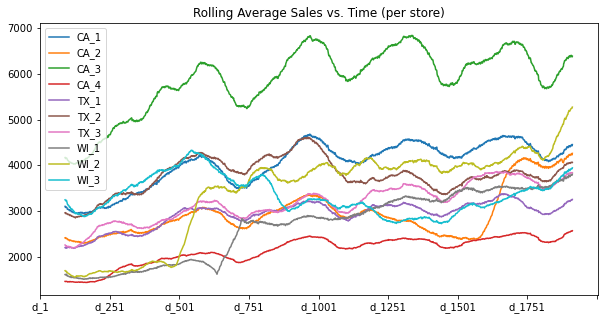

In [27]:
# Rolling Average Price vs. Time for each store
for i in train['store_id'].unique():
    train[train['store_id'] == i].iloc[:,6:].sum().rolling(90).mean().plot(label=i, figsize=(10, 5))
    plt.legend()
plt.title("Rolling Average Sales vs. Time (per store)");

На приведенном выше графике скользящие продажи по всем магазинам в наборе данных. Почти каждая кривая продаж имеет тенденцию "линейного колебания" на макроскопическом уровне. В принципе, продажи колеблются как синусоидальная волна вокруг определенного среднего значения, но это среднее значение имеет линейный тренд вверх. Это означает, что продажи колеблются на все более высоком уровне каждые несколько месяцев.

Эта тенденция напоминает деловой цикл, когда экономика испытывает краткосрочные колебательные колебания, но в долгосрочной перспективе растет линейно. Возможно, такие небольшие тенденции на уровне магазинов в совокупности определяют тенденции, которые мы наблюдаем на макроэкономическом уровне. 

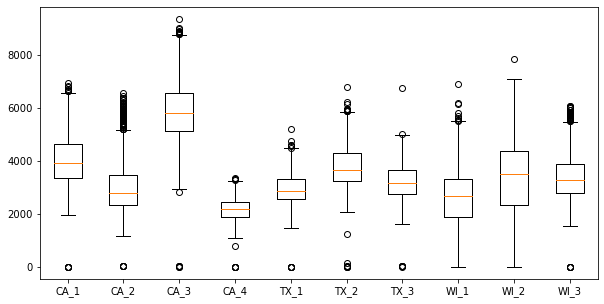

In [28]:
a = train.groupby('store_id').sum()
plt.figure(figsize=(10, 5))
plt.boxplot(a,labels=a.index);

На приведенном выше графике сравнивается распределение продаж для каждого магазина в наборе данных. Магазины в Калифорнии, похоже, имеют самую высокую разницу в продажах, что может указывать на то, что некоторые места в Калифорнии растут значительно быстрее, чем другие, т.е. существует неравенство в развитии. С другой стороны, продажи в Висконсине и Техасе, похоже, вполне согласуются между собой, без особых различий. Это указывает на то, что развитие может быть более равномерным в этих государствах. Более того, в калифорнийских магазинах, похоже, также самые высокие средние продажи.

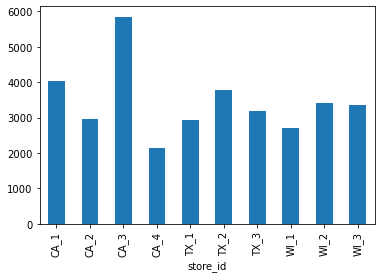

In [29]:
train.groupby('store_id').sum().mean(axis=1).plot(kind='bar');

На приведенном выше графике мы видим те же тенденции: магазины Калифорнии имеют самую высокую дисперсию и средние продажи среди всех магазинов в наборе данных.

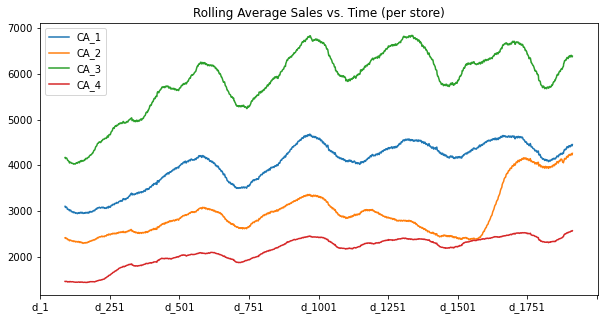

In [30]:
# California
ca = train[train['state_id'] == 'CA']
for i in ca['store_id'].unique():
    ca[ca['store_id'] == i].iloc[:,6:].sum().rolling(90).mean().plot(label=i, figsize=(10, 5))
    plt.legend()
plt.title("Rolling Average Sales vs. Time (per store)");

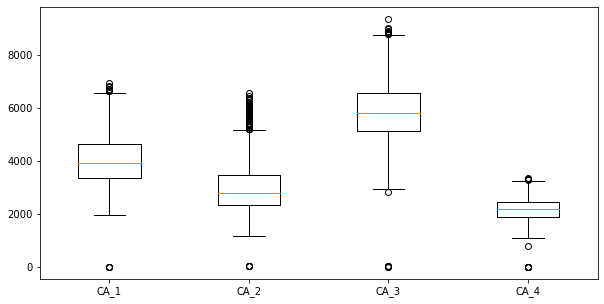

In [31]:
a = ca.groupby('store_id').sum()
plt.figure(figsize=(10, 5))
plt.boxplot(a,labels=a.index);

На приведенном выше графике мы видим большое различие в продажах между калифорнийскими магазинами. Кривые продаж почти никогда не пересекаются друг с другом. Это может указывать на то, что в Калифорнии существуют определенные "центры" развития, которые не меняются с течением времени. И другие области всегда остаются за этими "узлами". Средние продажи в порядке убывания составляют CA_3, CA_1, CA_2, CA_4. Магазин CA_3 имеет максимальные продажи, в то время как магазин CA_4 имеет минимальные продажи.

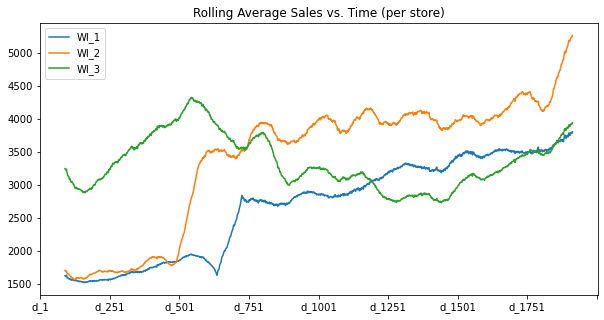

In [32]:
# Wisconsin
wi = train[train['state_id'] == 'WI']
for i in wi['store_id'].unique():
    wi[wi['store_id'] == i].iloc[:,6:].sum().rolling(90).mean().plot(label=i, figsize=(10, 5))
    plt.legend()
plt.title("Rolling Average Sales vs. Time (per store)");

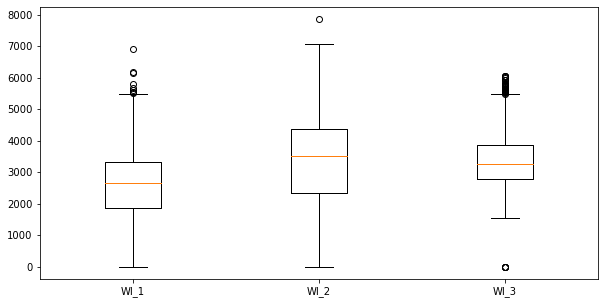

In [33]:
a = wi.groupby('store_id').sum()
plt.figure(figsize=(10, 5))
plt.boxplot(a,labels=a.index);

На приведенном выше графике мы видим очень низкое неравенство в продажах среди магазинов штата Висконсин. Кривые продаж очень часто пересекаются друг с другом. Это может указывать на то, что в большинстве районов Висконсина наблюдается аналогичная "кривая развития" и что в развитии по всему штату наблюдается большая справедливость. Нет никаких конкретных "горячих точек" или "центров" развития. Средние продажи в порядке убывания составляют WI_2, WI_3, WI_1. Магазин WI_2 имеет максимальные продажи, в то время как магазин WI_1 имеет минимальные продажи.

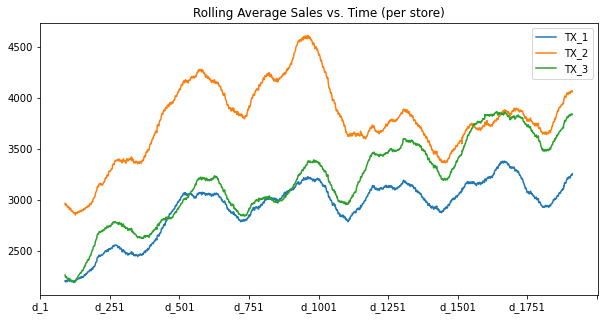

In [34]:
# Texas
tx = train[train['state_id'] == 'TX']
for i in tx['store_id'].unique():
    tx[tx['store_id'] == i].iloc[:,6:].sum().rolling(90).mean().plot(label=i, figsize=(10, 5))
    plt.legend()
plt.title("Rolling Average Sales vs. Time (per store)");

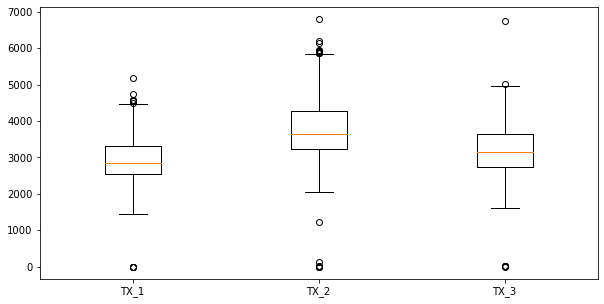

In [35]:
a = tx.groupby('store_id').sum()
plt.figure(figsize=(10, 5))
plt.boxplot(a,labels=a.index);

На приведенном выше графике мы еще раз видим, что очень низкая разница в продажах среди магазинов Техаса. Кривые продаж часто пересекаются, хотя и не так часто, как в Висконсине. Это может еще раз указывать на то, что большинство районов Техаса имеют аналогичную "кривую развития" и что в развитии по всему штату наблюдается большая справедливость. Разница здесь, однако, выше, чем в Висконсине, поэтому в Техасе также могут быть "центры" развития, но не столь выраженные, как в Калифорнии. Средние продажи в порядке убывания равны TX_2, TX_3, TX_1. Магазин TX_2 имеет максимальные продажи, в то время как магазин TX_1 имеет минимальные продажи.

# Model

**Train/Val split**  
Продажи за последние 30 дней в качестве данных проверки, а продажи за 70 дней до этого в качестве данных обучения. 

In [21]:
# все колонки, начинающиеся на d
d_cols = [c for c in train.columns if 'd_' in c]

train_dataset = train[d_cols[-100:-30]] # 70 дней до 30ти последних дней
val_dataset = train[d_cols[-30:]] # 30 последних дней

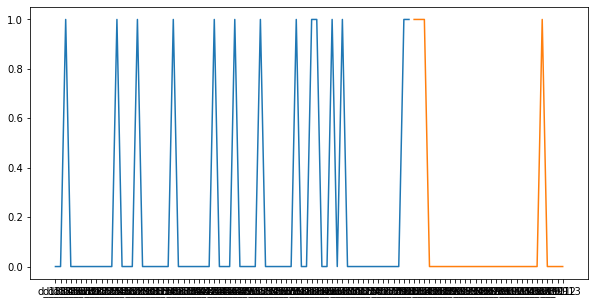

In [22]:
# случайная выборка для иллюстрации
smp_train = x.loc[train_dataset.columns, 1]
smp_val = x.loc[val_dataset.columns, 1]

plt.figure(figsize=(10, 5))
plt.plot(smp_train)
plt.plot(smp_val);

### Naive approach
Первый подход - это очень простой наивный подход. Он просто прогнозирует продажи на следующий день как продажи текущего дня.

yt+1 - это прогнозируемое значение продаж на следующий день, а yt - сегодняшние продажи. Модель предсказывает завтрашние продажи как сегодняшние продажи.   
Данные обучения выделены синим цветом, данные проверки - оранжевым, а прогнозы - зеленым.

In [23]:
predictions = []
for i in range(len(val_dataset.columns)):
    if i == 0:
        predictions.append(train_dataset[train_dataset.columns[-1]].values)
    else:
        predictions.append(val_dataset[val_dataset.columns[i-1]].values)
    
predictions = np.transpose(np.array([row.tolist() for row in predictions])) # сделали нумпай массивом
error_naive = np.linalg.norm(predictions - val_dataset.values)/len(predictions[0])

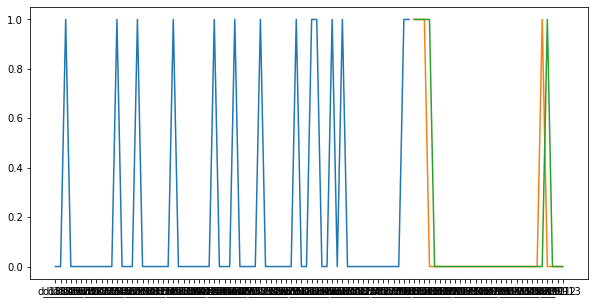

In [24]:
# наш х предсказанный
pred_x = predictions[1]

plt.figure(figsize=(10, 5))
plt.plot(smp_train)
plt.plot(smp_val)
plt.plot(pd.DataFrame(pred_x, index=smp_val.index));

Мы видим, что прогнозы, сделанные с помощью наивного подхода, не являются точными, и этого следует ожидать от такого простого алгоритма. Нам нужны более сложные модели, которые используют несколько временных меток для составления прогнозов.

### Moving average
Метод скользящей средней более сложен, чем наивный подход. Он вычисляет средние продажи за предыдущие 30 (или любое другое число) дней и прогнозирует их как продажи на следующий день. Этот метод учитывает предыдущие 30 временных шагов и поэтому менее подвержен краткосрочным колебаниям, чем наивный подход. 

yt+1 - это завтрашние продажи. Все продажи за предыдущие 30 дней суммируются и делятся на 30, чтобы найти среднее значение. Это формирует прогноз модели, yt+1.

Данные обучения выделены синим цветом, данные проверки - оранжевым, а прогнозы - зеленым.

In [25]:
predictions = np.zeros(val_dataset.shape)

for i in range(len(val_dataset.columns)):
    if i == 0:
        # заполняем конец по средним 30ти последним значениям трейна
        samples_train = np.mean(train_dataset[train_dataset.columns[-30:]].values, axis=1)
        predictions[:, i] = samples_train

    elif 0 < i < 31:
        # заполняем начало
        samples_train_pred = np.mean(
            np.c_[train_dataset[train_dataset.columns[-30 + i :]].values,  # the train part
                      predictions[:, :i]],                                 # the predicted part
            axis=1,
        )
        predictions[:, i] = samples_train_pred
    else:
        samples_pred = np.mean(predictions, axis=1)
        predictions[:, i] = samples_pred

l2_norm = np.linalg.norm(predictions - val_dataset.values)
error_avg = l2_norm / predictions.shape[1]

In [ ]:
# predictions = []
# for i in range(len(val_dataset.columns)):
#     if i == 0:
        
#         predictions.append(np.mean(train_dataset[train_dataset.columns[-30:]].values, axis=1)) 
#     if i < 31 and i > 0:
        
#         predictions.append(0.5 * (np.mean(train_dataset[train_dataset.columns[-30+i:]].values, axis=1) + \
#                                   np.mean(predictions[:i], axis=0)))
#     if i > 31:
#         predictions.append(np.mean([predictions[:i]], axis=1))
    
# predictions = np.transpose(np.array([row.tolist() for row in predictions]))
# error_avg = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

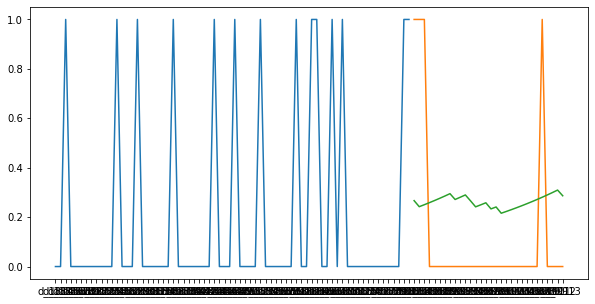

In [26]:
# наш х предсказанный
pred_x = predictions[1]

plt.figure(figsize=(10, 5))
plt.plot(smp_train)
plt.plot(smp_val)
plt.plot(pd.DataFrame(pred_x, index=smp_val.index));

Мы видим, что эта модель работает лучше, чем наивный подход. Он менее подвержен волатильности в ежедневных данных о продажах и умеет улавливать тенденции с несколько большей точностью. Тем не менее, он по-прежнему не может найти тенденции высокого уровня в продажах.

### Holt linear
Линейный метод Холта полностью отличается от первых двух методов. Линейный Холт пытается зафиксировать высокоуровневые тенденции в данных временных рядов с помощью линейной функции. 

α и β являются константами, которые можно настроить.Значение тренда - это наклон линейной функции прогноза, а значение уровня - перехват y линейной функции прогноза. Значения наклона и y-перехвата непрерывно обновляются. Наконец, значения наклона и y-перехвата используются для расчета прогноза, yt+h, что на h шагов опережает текущий временной шаг. 

In [27]:
predictions = []
for row in tqdm(train_dataset[train_dataset.columns[-30:]].values):
    fit = Holt(row).fit(smoothing_level = 0.3, smoothing_slope = 0.01)
    predictions.append(fit.forecast(30))
predictions = np.array(predictions).reshape((-1, 30))
error_holt = np.linalg.norm(predictions - val_dataset.values[:len(predictions)])/len(predictions[0])

  0%|          | 0/30490 [00:00<?, ?it/s]

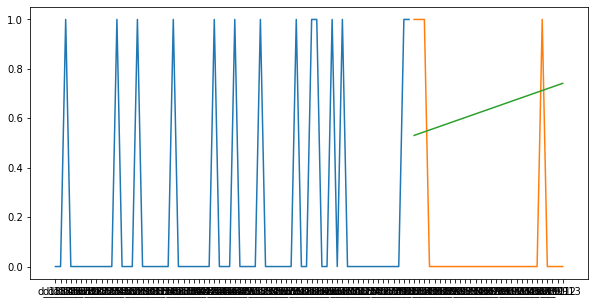

In [28]:
# наш х предсказанный
pred_x = predictions[1]

plt.figure(figsize=(10, 5))
plt.plot(smp_train)
plt.plot(smp_val)
plt.plot(pd.DataFrame(pred_x, index=smp_val.index));

Мы видим, что Holt linear способен очень последовательно прогнозировать высокие тенденции в продажах. Но он не способен фиксировать краткосрочную волатильность продаж так же точно, как другие методы. Возможно, этот метод можно объединить с другими низкоуровневыми прогнозистами для получения лучших результатов.

### Exponential smoothing
Метод экспоненциального сглаживания использует другой тип сглаживания, который отличается от среднего сглаживания. Предыдущие временные шаги экспоненциально взвешиваются и суммируются для создания прогноза. Веса уменьшаются по мере того, как мы движемся все дальше назад во времени.

α является параметром сглаживания. Прогноз yt+1 представляет собой средневзвешенное значение всех наблюдений в серии y1,...,yt. Скорость, с которой затухают веса, регулируется параметром α. Этот метод придает разный вес разным временным шагам, вместо того, чтобы придавать одинаковый вес всем временным шагам (например, метод скользящей средней). Это гарантирует, что при составлении прогноза последним данным о продажах придается большее значение, чем старым данным о продажах. 

In [29]:
predictions = []
for row in tqdm(train_dataset[train_dataset.columns[-30:]].values):
    fit = ExponentialSmoothing(row, seasonal_periods=3).fit()
    predictions.append(fit.forecast(30))
predictions = np.array(predictions).reshape((-1, 30))
error_exponential = np.linalg.norm(predictions - val_dataset.values)/len(predictions[0])

  0%|          | 0/30490 [00:00<?, ?it/s]

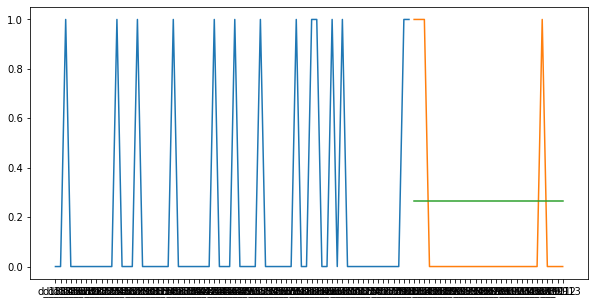

In [30]:
# наш х предсказанный
pred_x = predictions[1]

plt.figure(figsize=(10, 5))
plt.plot(smp_train)
plt.plot(smp_val)
plt.plot(pd.DataFrame(pred_x, index=smp_val.index));

Мы видим, что экспоненциальное сглаживание создает горизонтальную линию. Это связано с тем, что он придает очень низкий вес отдаленным временным шагам, в результате чего прогнозы выравниваются или остаются постоянными. Тем не менее, он способен прогнозировать средние продажи с отличной точностью.

# ARIMA
ARIMA расшифровывается как Авторегрессивная Интегрированная скользящая средняя. В то время как модели экспоненциального сглаживания были основаны на описании тенденции и сезонности в данных, модели ARIMA нацелены на описание корреляций во временных рядах.

In [31]:
predictions = []
for row in tqdm(train_dataset[train_dataset.columns[-30:]].values):
    # initialization='approximate_diffuse' - fix error
    fit = sm.tsa.statespace.SARIMAX(row, seasonal_order=(0, 1, 1, 7), initialization='approximate_diffuse').fit()
    predictions.append(fit.forecast(30))
predictions = np.array(predictions).reshape((-1, 30))
error_arima = np.linalg.norm(predictions - val_dataset.values)/len(predictions[0])

  0%|          | 0/30490 [00:00<?, ?it/s]

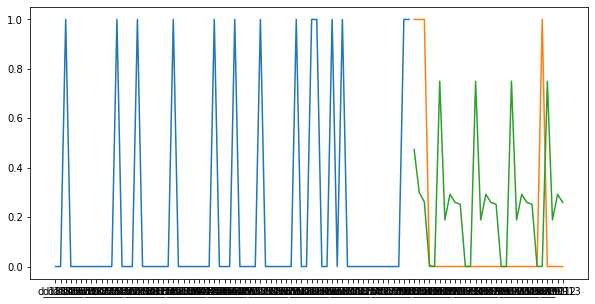

In [32]:
# наш х предсказанный
pred_x = predictions[1]

plt.figure(figsize=(10, 5))
plt.plot(smp_train)
plt.plot(smp_val)
plt.plot(pd.DataFrame(pred_x, index=smp_val.index));

ARIMA способна находить тренды низкого и высокого уровня одновременно, в отличие от большинства других моделей, которые могут найти только один из них. Он способен предсказывать периодическую функцию для каждого образца, и эти функции кажутся довольно точными, но не в данном случае

### Prophet
Prophet - это проект Facebook по прогнозированию временных рядов с открытым исходным кодом. Он основан на аддитивной модели, в которой нелинейные тенденции соответствуют годовой, еженедельной и ежедневной сезонности, включая праздничные эффекты. Он лучше всего работает с временными рядами, которые имеют сильные сезонные эффекты и несколько сезонов исторических данных. Предполагается также, что он будет более устойчив к отсутствующим данным и изменениям в тенденциях по сравнению с другими моделями.

In [41]:
dates = ["2007-12-" + str(i) for i in range(1, 31)]
predictions = []
# обрезали датасет первыми 10-ти значениями, иначе долго считает
for row in tqdm(train_dataset[train_dataset.columns[-30:]].values[:10]): 
    df = pd.DataFrame(np.transpose([dates, row]))
    df.columns = ["ds", "y"]
    model = Prophet(daily_seasonality=True)
    model.fit(df)
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)["yhat"].loc[30:].values
    predictions.append(forecast)
predictions = np.array(predictions).reshape((-1, 30))
error_prophet = np.linalg.norm(predictions - val_dataset.values[:10])/len(predictions[0])

  0%|          | 0/10 [00:00<?, ?it/s]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to overri

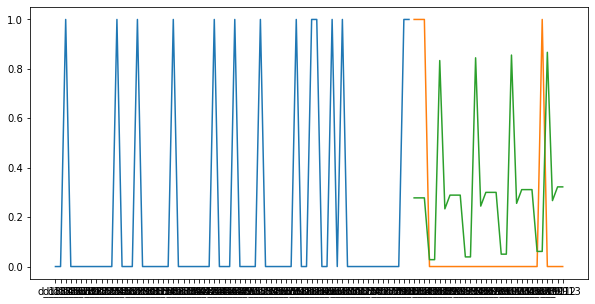

In [42]:
# наш х предсказанный
pred_x = predictions[1]

plt.figure(figsize=(10, 5))
plt.plot(smp_train)
plt.plot(smp_val)
plt.plot(pd.DataFrame(pred_x, index=smp_val.index));

Пропет, по-видимому, выдает очень похожие по форме предсказания АРИМЕ. Но при ближайшем рассмотрении мы можем увидеть, что существует макроскопическая тенденция к росту, которая отсутствовала в ARIMA. В предсказаниях ARIMA повторялась точно такая же картина. Но в предсказаниях Пропета один и тот же паттерн смещается по вертикали при каждом колебании. Это показывает, что он способен улавливать тенденции высокого уровня лучше, чем ARIMA.

### submit

In [43]:
days = range(1, 1913 + 1) # 1 - 1914
time_series_columns = [f'd_{i}' for i in days]
time_series_data = train[time_series_columns]
# средние продажи за последние 28 дней
forecast = pd.DataFrame(time_series_data.iloc[:, -28:].mean(axis=1))
# продублировали 28 раз 
forecast = pd.concat([forecast] * 28, axis=1)
forecast.columns = [f'F{i}' for i in range(1, forecast.shape[1] + 1)] # F1 - F28
validation_ids = train['id'].values # id train
evaluation_ids = [i.replace('validation', 'evaluation') for i in validation_ids]
# все индексы и трейна и теста
ids = np.concatenate([validation_ids, evaluation_ids])
# столбец индексов
predictions = pd.DataFrame(ids, columns=['id'])
# дублируем прогноз для evaluation_ids
forecast = pd.concat([forecast] * 2).reset_index(drop=True)
predictions = pd.concat([predictions, forecast], axis=1)
predictions.to_csv('base_submission_v1.csv', index=False)

In [44]:
predictions

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286
1,HOBBIES_1_002_CA_1_validation,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429
2,HOBBIES_1_003_CA_1_validation,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429
3,HOBBIES_1_004_CA_1_validation,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429
4,HOBBIES_1_005_CA_1_validation,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286
60976,FOODS_3_824_WI_3_evaluation,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429
60977,FOODS_3_825_WI_3_evaluation,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857
60978,FOODS_3_826_WI_3_evaluation,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571


### Loss for each model

In [45]:
# error = [error_naive, error_avg, error_holt, error_exponential, error_arima, error_prophet]
# names = ["Naive approach", "Moving average", "Holt linear", "Exponential smoothing", "ARIMA", "Prophet"]
# df = pd.DataFrame(np.transpose([error, names]))
# df.columns = ["RMSE Loss", "Model"]
# px.bar(df, y="RMSE Loss", x="Model", color="Model", title="RMSE Loss vs. Model")

error = [error_naive, error_avg, error_holt, error_exponential, error_arima]
names = ["Naive approach", "Moving average", "Holt linear", "Exponential smoothing", "ARIMA"]
df = pd.DataFrame(np.transpose([error, names]))
df.columns = ["RMSE Loss", "Model"]
df

,RMSE Loss,Model
0,83.2445527080034,Naive approach
1,71.87699299538848,Moving average
2,82.74132407317535,Holt linear
3,73.57962464749173,Exponential smoothing
4,78.4214068050134,ARIMA


Скользящее среднее и экспоненциальное сглаживание являются наиболее результативными моделями. Холт Линеар не сильно отстает. Остальные модели: наивный подход, АРИМА и Пропет - это модели с худшими показателями. Точность ARIMA и Prophet можно значительно повысить, настроив гиперпараметры.

### Takeaways
* Разные штаты имеют разное среднее значение и дисперсию продаж, что указывает на различия в распределении развития в этих штатах.

* Большинство продаж имеют линейно направленную синусоидальную форму, напоминающую макроэкономический деловой цикл.

* Для прогнозирования данных временных рядов можно использовать несколько моделей, не относящихся к ML. Скользящая средняя и экспоненциальное сглаживание - очень хорошие модели.

* Производительность ARIMA и Prophet можно повысить с помощью дополнительной настройки гиперпараметров.

test score = 1.08216